# Model Comparison: Credit Card Default Prediction

This notebook explores multiple machine learning models including logistic regression, tree-based models, and a neural network (ANN). The best-performing model will be selected and saved.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import set_random_seed

import joblib
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load and prepare data
df = pd.read_csv("default_of_credit_card_clients.csv")
df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.drop(columns=['ID'], inplace=True)

X = df.drop(columns='default')
y = df['default']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
# Dictionary to hold models and results
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

# Fit and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    results[name] = auc
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000

--------------------------------------------------
Model: Random Forest
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.63      0.36      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

--------------------------------------------------
Model: SVM
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.34      0.45      1327

    accuracy         

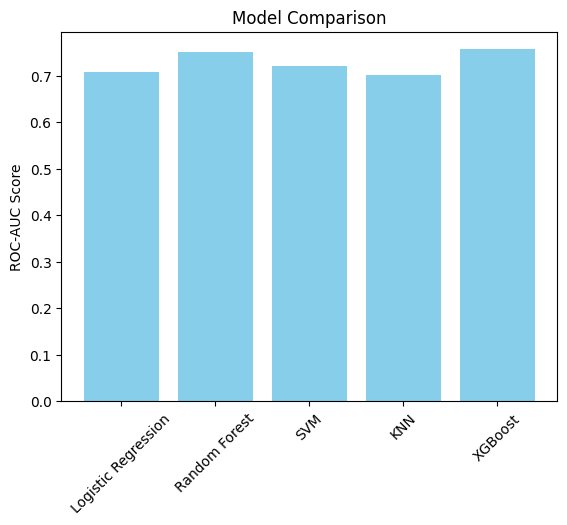

In [4]:
# Plot AUC scores
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("ROC-AUC Score")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.show()

In [5]:
# Neural Network Model
set_random_seed(42)
ann = Sequential()
ann.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = ann.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

# Evaluate
ann_proba = ann.predict(X_test_scaled).ravel()
ann_pred = (ann_proba > 0.5).astype(int)
ann_auc = roc_auc_score(y_test, ann_proba)
results["ANN"] = ann_auc

print("Neural Network (ANN):")
print(classification_report(y_test, ann_pred))

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
Neural Network (ANN):
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      4673
           1       0.63      0.40      0.49      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.67      0.69      6000
weighted avg       0.80      0.81      0.80      6000



In [7]:
# Determine the best model
best_model_name = max(results, key=results.get)
print(f"Best model based on ROC-AUC: {best_model_name}")

if best_model_name == "ANN":
    ann.save("outputs/models/best_model_ann.h5")
else:
    best_model = models[best_model_name]
    joblib.dump(best_model, "best_model.pkl")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")


Best model based on ROC-AUC: ANN


['scaler.pkl']